In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import spacy

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


In [57]:
SRC_LANG = "en"
TRG_LANG = "pl"

In [32]:
!python -m spacy download en_core_web_sm
!python -m spacy download pl_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.2 MB/s eta 0:00:00:00:01:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 78.4 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [58]:
spacy_src = spacy.load("en_core_web_sm")
spacy_trg = spacy.load("pl_core_news_sm")

In [59]:
data = load_dataset("Helsinki-NLP/europarl", f"{SRC_LANG}-{TRG_LANG}")
split_data = data['train'].train_test_split(test_size=0.1)
train_data = split_data['train'].select(range(5000))
val_data = split_data['test'].select(range(1000))

In [60]:
def tokenize(text, tokenizer):
    return [tok.text.lower() for tok in tokenizer(text)]

In [35]:
def build_vocab(sentences, tokenizer, max_size=10000):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenize(sentence, tokenizer))
    vocab = {word: idx+4 for idx, (word, _) in enumerate(counter.most_common(max_size))}
    vocab["<pad>"] = 0
    vocab["<sos>"] = 1
    vocab["<eos>"] = 2
    vocab["<unk>"] = 3
    return vocab

In [61]:
train_data

Dataset({
    features: ['translation'],
    num_rows: 5000
})

In [37]:
src_sentences = [ex['translation'][SRC_LANG] for ex in train_data]
trg_sentences = [ex['translation'][TRG_LANG] for ex in train_data]

# src_sentences = [ex['translation'][SRC_LANG] for ex in train_data.select(range(5000))]
# trg_sentences = [ex['translation'][TRG_LANG] for ex in train_data.select(range(5000))]

In [62]:
src_sentences[:5]

['in writing. - (HU) Globalisation, demographic changes and increased transport are contributing significantly to the rapid growth in tourism, which has great potential for growth and employment.',
 "It condemns the European Commission's over-willingness to compromise, and stresses that decisions to open up to new markets must not have a negative impact on EU farmers.",
 "For the rest, the agreements negotiated with dictatorships are set to live on: free trade areas, outsourcing the 'management of migration flows', the EU's energy security - everything is there.",
 'My thanks to the rapporteur for drafting such a comprehensive document.',
 'Let us not forget that farmers are environmentalists by nature!']

In [39]:
SRC_VOCAB = build_vocab(src_sentences, spacy_src)
TRG_VOCAB = build_vocab(trg_sentences, spacy_trg)

In [40]:
def numericalize(text, vocab, tokenizer):
    return [vocab.get(tok, vocab['<unk>']) for tok in tokenize(text, tokenizer)]

In [41]:
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for example in batch:
        src = numericalize(example['translation'][SRC_LANG], SRC_VOCAB, spacy_src)
        trg = numericalize(example['translation'][TRG_LANG], TRG_VOCAB, spacy_trg)
        src_batch.append(torch.tensor([SRC_VOCAB['<sos>']] + src + [SRC_VOCAB['<eos>']]))
        trg_batch.append(torch.tensor([TRG_VOCAB['<sos>']] + trg + [TRG_VOCAB['<eos>']]))
    src_batch = pad_sequence(src_batch, padding_value=SRC_VOCAB['<pad>'])
    trg_batch = pad_sequence(trg_batch, padding_value=TRG_VOCAB['<pad>'])
    return src_batch.to(device), trg_batch.to(device)

In [42]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [43]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=SRC_VOCAB['<pad>'])
        self.rnn = nn.GRU(emb_dim, hid_dim)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

In [44]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        src_len = encoder_outputs.shape[0]
        hidden = hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


In [45]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, attention):
        super().__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=TRG_VOCAB['<pad>'])
        self.rnn = nn.GRU(hid_dim + emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim * 2 + emb_dim, output_dim)
        self.attention = attention

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = torch.cat((embedded.squeeze(0), weighted.squeeze(0), output.squeeze(0)), dim=1)
        prediction = self.fc_out(output)
        return prediction, hidden, a.squeeze(1)

In [46]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        max_len = trg.shape[0]
        batch_size = trg.shape[1]
        trg_vocab_size = self.decoder.embedding.num_embeddings
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]

        for t in range(1, max_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            top1 = output.argmax(1)
            input = trg[t] if torch.rand(1).item() < teacher_forcing_ratio else top1

        return outputs


In [47]:
INPUT_DIM = len(SRC_VOCAB)
OUTPUT_DIM = len(TRG_VOCAB)
EMB_DIM = 256
HID_DIM = 512

In [48]:
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM).to(device)
attn = Attention(HID_DIM).to(device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, attn).to(device)

In [49]:
model = Seq2Seq(enc, dec).to(device)

In [50]:
PAD_IDX = TRG_VOCAB['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters())

In [63]:
def train_epoch(model, loader):
    model.train()
    epoch_loss = 0
    for src, trg in loader:
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

In [65]:
train_losses = []

In [66]:
for epoch in range(10):
    loss = train_epoch(model, train_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 5.2744
Epoch 2, Loss: 4.4634
Epoch 3, Loss: 3.7011
Epoch 4, Loss: 3.0524
Epoch 5, Loss: 2.5826
Epoch 6, Loss: 2.2737
Epoch 7, Loss: 1.9916
Epoch 8, Loss: 1.7325
Epoch 9, Loss: 1.5306
Epoch 10, Loss: 1.3296


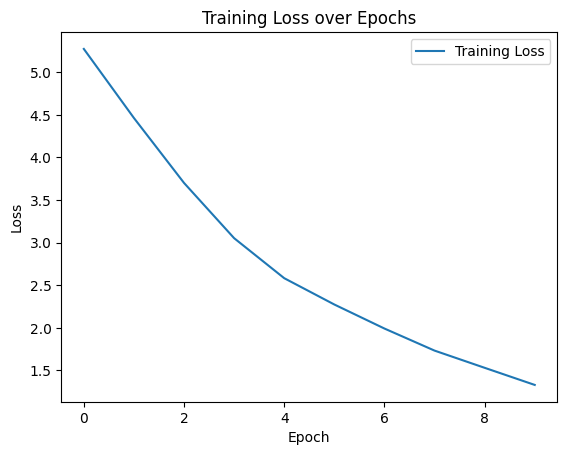

In [ ]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss over Epochs")
plt.show()

In [82]:
def visualize_attention(attentions, src_tokens, trg_tokens):
    import seaborn as sns
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(np.stack(attentions).squeeze(1)[:len(trg_tokens), :len(src_tokens)],
                xticklabels=src_tokens,
                yticklabels=trg_tokens,
                cmap='viridis', cbar=True, ax=ax)
    ax.set_xlabel('Source sentence')
    ax.set_ylabel('Target sentence')
    plt.title('Attention Heatmap')
    plt.show()

In [74]:
def translate_sentence(model, sentence):
    model.eval()
    tokens = [SRC_VOCAB.get(tok, SRC_VOCAB['<unk>']) for tok in tokenize(sentence, spacy_src)]
    src_tensor = torch.tensor([SRC_VOCAB['<sos>']] + tokens + [SRC_VOCAB['<eos>']]).unsqueeze(1).to(device)
    encoder_outputs, hidden = model.encoder(src_tensor)
    trg_indices = [TRG_VOCAB['<sos>']]
    attentions = []

    for i in range(50):
        trg_tensor = torch.tensor([trg_indices[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions.append(attention.cpu().numpy())
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)
        if pred_token == TRG_VOCAB['<eos>']:
            break

    trg_tokens = [list(TRG_VOCAB.keys())[list(TRG_VOCAB.values()).index(i)] for i in trg_indices[1:-1]]
    src_tokens = tokenize(sentence, spacy_src)
    visualize_attention(attentions, src_tokens, trg_tokens)
    return trg_tokens



Input 1: We cannot afford to marginalise Russia, we have to engage with it in a constructive way.


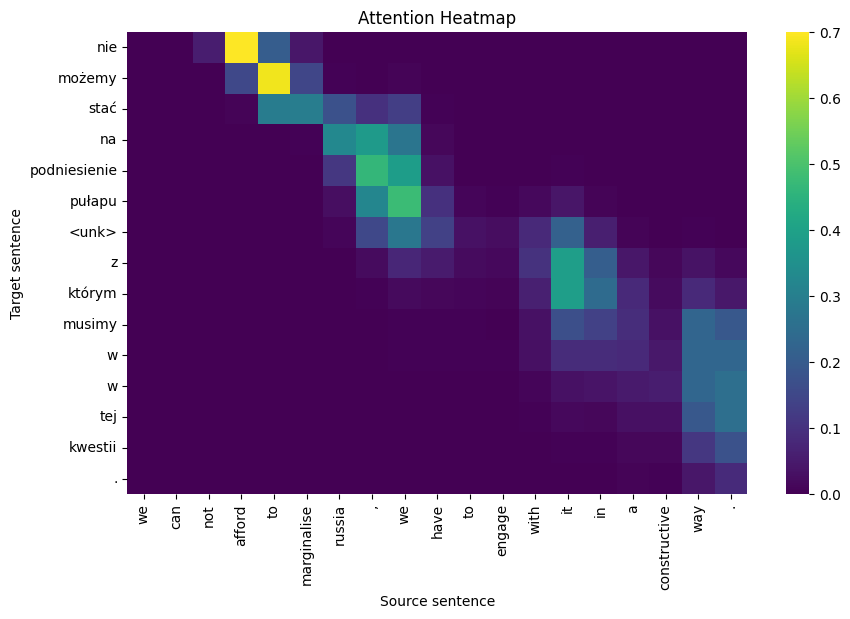

Prediction: nie możemy stać na podniesienie pułapu <unk> z którym musimy w w tej kwestii .

Input 2: My next point is that I have been accused of concealing the voluntary nature of the tests.


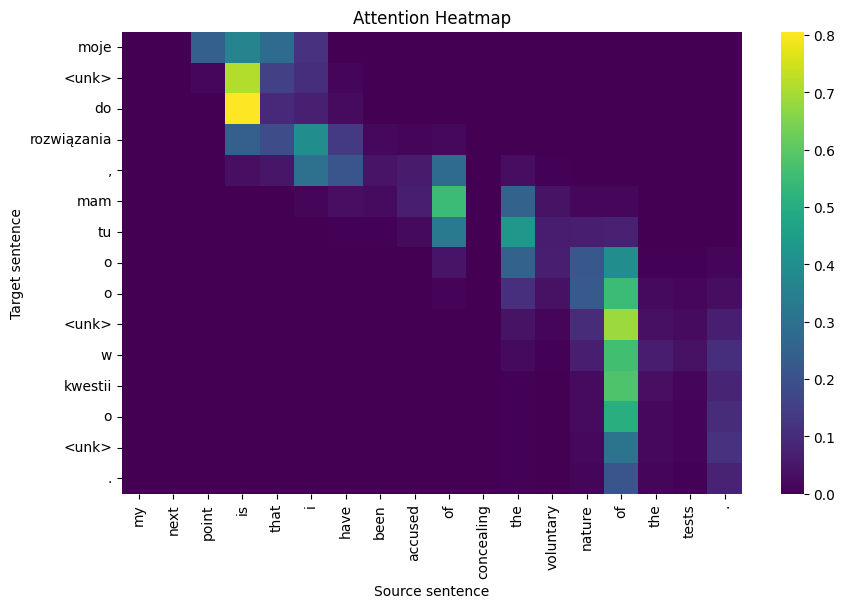

Prediction: moje <unk> do rozwiązania , mam tu o o <unk> w kwestii o <unk> .

Input 3: I very much support the decision to deploy 26 000 UN peacekeepers in Sudan.


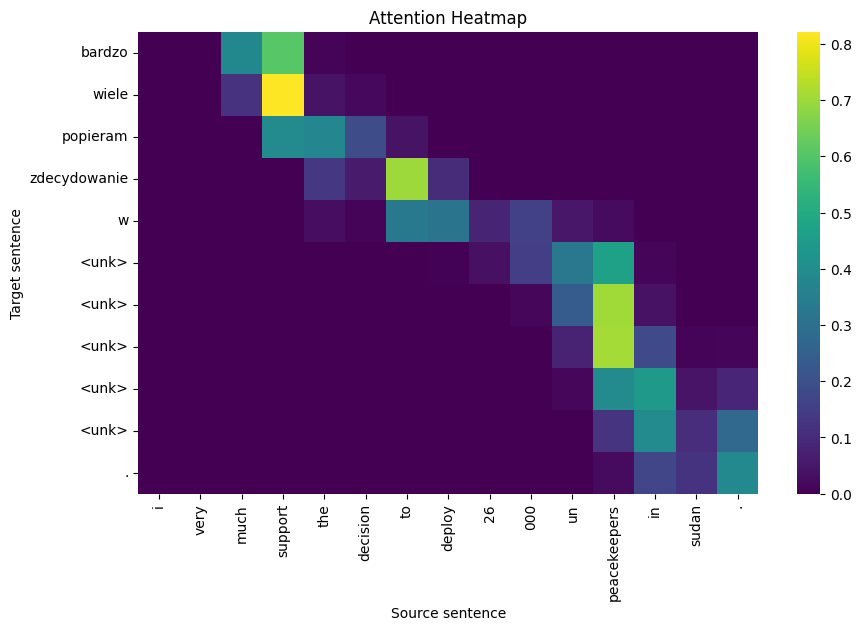

Prediction: bardzo wiele popieram zdecydowanie w <unk> <unk> <unk> <unk> <unk> .


In [84]:
for i in range(3):
    example = val_data[i]['translation'][SRC_LANG]
    print(f"\nInput {i+1}:", example)
    print("Prediction:", " ".join(translate_sentence(model, example)))

Аналіз втрат (Loss):

✅ Позитив:

Loss стабільно зменшується, особливо помітно між епохами 1–5.

Навчання проходить коректно — модель навчається та поступово вивчає шаблони мови.

⚠️ Спостереження:

Після 7–8 епох темп зниження сповільнюється — це нормально.

Можна зупинитися на 10 епохах або продовжити ще кілька з меншою швидкістю навчання.

** Аналіз перекладу:**
- Вхідне речення:

We cannot afford to marginalise Russia, we have to engage with it in a constructive way.

- Переклад моделі:

nie możemy stać na podniesienie pułapu <unk> z którym musimy w w tej kwestii .


✅ **Плюси:**
Модель уловила структуру перекладу на польську:
nie możemy ... musimy ... w tej kwestii — це граматично природні шаблони.

Стиль перекладу приблизно відображає зміст: йдеться про «не можемо стояти осторонь, мусимо взаємодіяти».

⚠️ **Недоліки**:
З’явився <unk> — це означає, що модель не знає деяке слово (швидше за все “Russia”).

Частина речення звучить незрозуміло:

"na podniesienie pułapu <unk> z którym musimy w w tej kwestii"

Тут є і семантична помилка, і дубльоване слово "w w".

**Heatmap** також відображає, що модельне впевненно фокусується на перекладі кожного слова

Як можна покращити:

- Розширити словник:

    - Під час build_vocab збільшити max_size до 20,000+.

    - Створити словник на повному train_data, не лише на 5000 прикладах. Зменшення даних було використано для прискорення навчання моделві

- Замінити <unk> токени:

    - Після output.argmax(1) перевіряти, чи це <unk>, і застосовувати постобробку або копіювання зі вхідного речення.